In [2]:
execfile ("D:/measuring/analysis/scripts/setup_analysis.py")

import os, sys 
from os import listdir 
from os.path import isfile, join 
import numpy as np 
import matplotlib.pyplot as plt 
import h5py
from analysis.lib.tools import toolbox

from analysis.lib.fitting import fit, common

%matplotlib inline 



from analysis.lib.pq import pq_tools
reload(pq_tools)

reloaded


<module 'analysis.lib.pq.pq_tools' from 'd:/measuring\analysis\lib\pq\pq_tools.pyc'>

In [3]:
folder=tb.latest_data('092721')
print folder
h5filepath = toolbox.measurement_filename(folder)
#h5mode=kw.get('hdf5_mode', 'r')
pqf = h5py.File(h5filepath,'r')

d:\measuring\data\20170131\092721_QTelecom_TPQI_telecom13


(<matplotlib.figure.Figure at 0x4b76b90>,
 (<matplotlib.axes._subplots.AxesSubplot at 0xa0fba70>,
  <matplotlib.axes._subplots.AxesSubplot at 0xa24c6d0>))

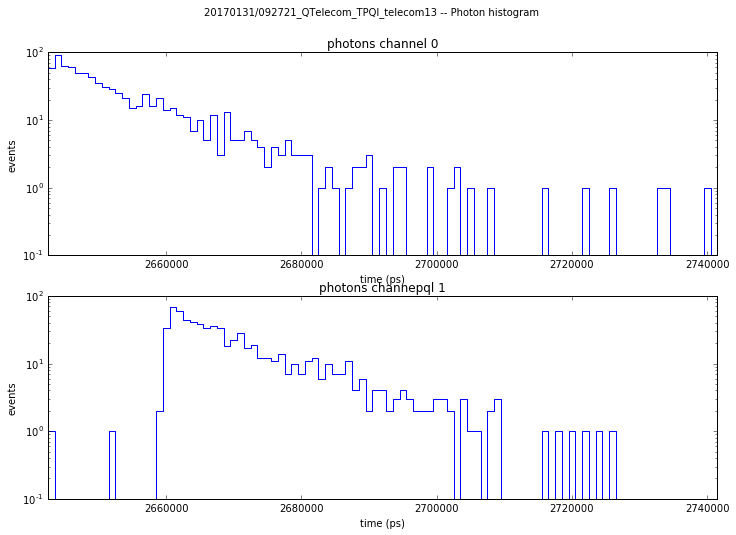

In [4]:
#pq_tools.get_photon_hist(pqf, start = 0, length = 3e6, hist_binsize = 10)
pq_tools.plot_photon_hist(pqf, start = 2444.5e3 + 198e3 , length = 100e3, hist_binsize = 1000)

In [5]:
pq_binsize_ns = 1e-3
start_ns = 2444.5 + 198
hist_binsize_ns = 0.2
tail_length_ns = 40
reps = 50000
syncs_per_sweep = 50
sync_nrs=pqf['/PQ_sync_number-1'].value
# syncs_per_sweep = 1
# reps = sync_nrs[-1]


sweep_pts = [0.1, 0.15833333, 0.21666667, 0.275, 0.33333333, 0.39166667, 0.45,0.50833333, 0.56666667, 0.625, 0.68333333, 0.74166667, 0.8]
sweep_pts = [0.1]
is_ph = pq_tools.get_photons(pqf)[0]
sweep_length = len(sweep_pts)
sweep_idxs=np.mod(np.floor((sync_nrs-1)/syncs_per_sweep),sweep_length)
 
sync_time_ns = pqf['/PQ_sync_time-1'].value * pq_binsize_ns
hist_bins = np.arange(start_ns-hist_binsize_ns*.5,start_ns+1*tail_length_ns+hist_binsize_ns,hist_binsize_ns)
tail_hist_h=np.zeros((sweep_length,len(hist_bins)-1))

st_fltr = (start_ns  <= sync_time_ns) &  (sync_time_ns< (start_ns + tail_length_ns))
print sum(sync_time_ns)
valid_tail_idxs = sweep_idxs[np.where(is_ph & st_fltr)]
tail_cts_per_sweep_idx=np.zeros(sweep_length)

for sweep_idx in range(sweep_length):
            tail_cts_per_sweep_idx[sweep_idx]= \
                                float(len(np.where(valid_tail_idxs==sweep_idx)[0])) / (reps*syncs_per_sweep/sweep_length)
            tail_hist_h[sweep_idx], tail_hist_b = \
                                np.histogram(sync_time_ns[np.where(is_ph & (sweep_idxs == sweep_idx))], 
                                             bins=hist_bins)
                


print 'total_photons in channel', 0, ':', len(sync_time_ns[np.where(is_ph)])  
print 'total_photons in window:', len(sync_time_ns[np.where(is_ph & st_fltr)]) 
print 'total_sweeps in window:', len(valid_tail_idxs) 
print 'total ph in window with sweep element 0:', len(np.where(valid_tail_idxs==0)[0])
print 'div factor:', (reps*syncs_per_sweep/sweep_length)

92332495.277
total_photons in channel 0 : 13100
total_photons in window: 803
total_sweeps in window: 803
total ph in window with sweep element 0: 803
div factor: 2500000


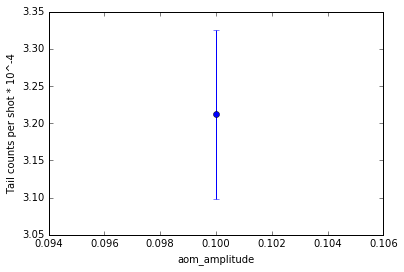

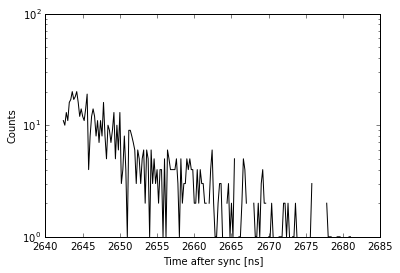

In [6]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1, 1, 1)

y_err=np.sqrt(tail_cts_per_sweep_idx)/np.sqrt((reps*syncs_per_sweep/sweep_length))
ax.errorbar(sweep_pts, tail_cts_per_sweep_idx*1e4, fmt='o',yerr=y_err*1e4)
  
ax.set_xlabel('aom_amplitude')
ax.set_ylabel('Tail counts per shot * 10^-4')

log_plot = True
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot(1, 1, 1)

xx=tail_hist_b[:-1]
yy=np.sum(tail_hist_h, axis=0)
if log_plot:
    ax.semilogy(xx,yy,'-', color = 'k')
else:
    ax.plot(xx,yy)
#ax.colorbar()
ax.set_xlabel('Time after sync [ns]')
ax.set_ylabel('Counts')


## Check delay time

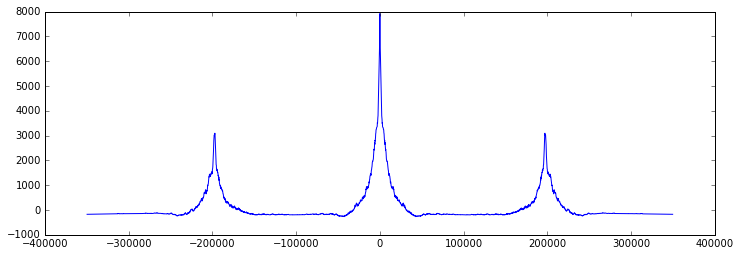

Delay is  197200.0


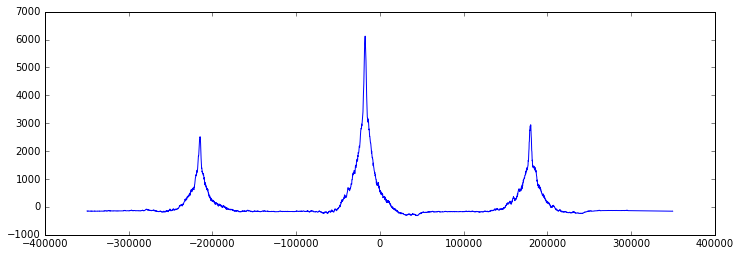

Delay is  -17600.0


In [165]:
def xcorr(a,v):
            
    xaxis = np.arange(len(a)) - len(a)/2
    return xaxis,np.correlate(np.array(a)-np.mean(a),np.array(v)-np.mean(v),'same')

(h0, b0), (h1, b1) = pq_tools.get_photon_hist(pqf,start = 2.4e6, length = 700e3, hist_binsize = 200)

xaxis,xcorr01_shifted=xcorr(h0,h0)
xaxis = (b0[1]-b0[0])*xaxis
fig, (ax0) = plt.subplots(figsize=(12,4))
plt.plot(xaxis,xcorr01_shifted)
plt.show()
plt.close('all')
xzero_ind = np.argmin(abs(xaxis-100000))
i = np.argmax(xcorr01_shifted[xzero_ind:])
print 'Delay is ', xaxis[xzero_ind+i]


xaxis,xcorr01_shifted=xcorr(h0,h1)
xaxis = (b0[1]-b0[0])*xaxis
fig, (ax0) = plt.subplots(figsize=(12,4))
plt.plot(xaxis,xcorr01_shifted)
plt.show()
plt.close('all')
i = np.argmax(xcorr01_shifted)
print 'Delay is ', xaxis[i]

In [17]:
is_phot0, is_phot1 = pq_tools.get_photons(pqf)
sync_time = pqf['/PQ_sync_time-1'].value

_fltr0 = is_phot0
_fltr1 = is_phot1

st0 = sync_time[_fltr0]
st1 = sync_time[_fltr1]


print st0[:5]/1000
#fltr = pq_tools.filter_synctimes(pqf, )

[2978 2979 2980 2781 2979]


In [71]:
print valid_tail_idxs[:10]

[]


In [9]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
folder=tb.latest_data('red_tail')
#folder=tb.data_from_time('20140707172303')
#folder=r'D:\measuring\data\20140519\192030_Bell_lt3_tailS_The111no2_SIL1_Ey_+11deg'
name = 'ssro'
a = pqsequence.TailAnalysis(folder, hdf5_mode='r')#, pq_folder='bs_remote')
#a.fix_sweep_pts('Pulse Amplitude', 'eom_pulse_amplitude')
#a.get_sweep_pts()
a.sweep_pts = range(13)#a.g.attrs['aom_amplitude']
a.sweep_name=''
#a.get_sweep_idxs(noof_syncs_per_sweep_pt=250)
#a.get_readout_results(name)
a.get_tail_vs_sweep(0,5378,140, pq_binsize_ns=1e-3, hist_binsize_ns=0.1,verbose=True)
#a.get_tail_vs_sweep(0,5380.5,100, pq_binsize_ns=1, hist_binsize_ns=1,verbose=True)

KeyError: "Unable to open object (Object 'ssro' doesn't exist)"

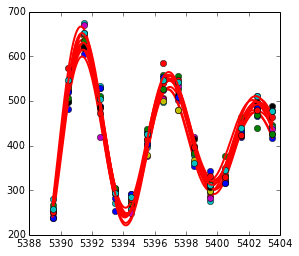

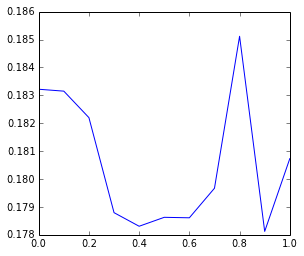

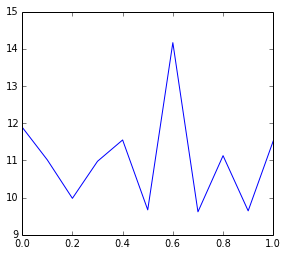

In [84]:
from analysis.lib.fitting import fit, common, rabi
from analysis.lib.tools import plot
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
fs=zeros(a.sweep_length)
taus = zeros(a.sweep_length)
for i in range(a.sweep_length):
    x=a.tail_hist_b[:-1]        
    y=a.tail_hist_h[i]
    fit_result = fit.fit1d(x, y, rabi.fit_rabi_damped_exp_with_offset, 
            1/5.,1000,0,10., x[0], ret = True, color = 'r', linewidth = 2.0)
    fs[i] = fit_result['params_dict']['f']
    taus[i] = fit_result['params_dict']['tau']
    plot.plot_fit1d(fit_result, np.linspace(x[0],x[-1],201), ax=ax,
        plot_data=True, print_info=False)
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
#print taus, fs
ax.plot(a.sweep_pts, fs)
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
ax.plot(a.sweep_pts, taus)


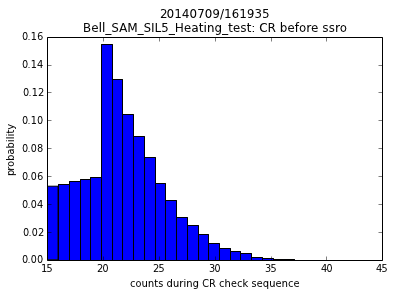

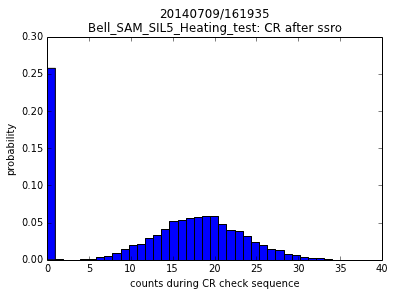

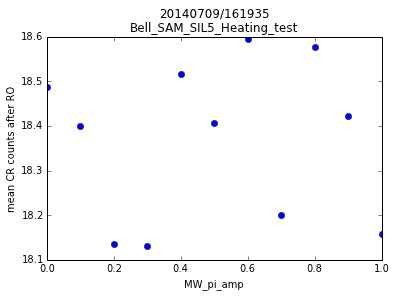

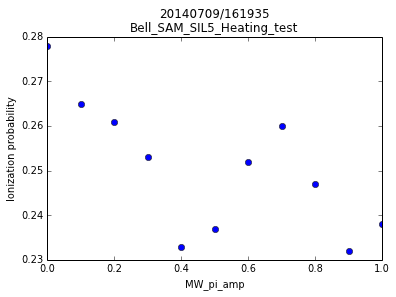

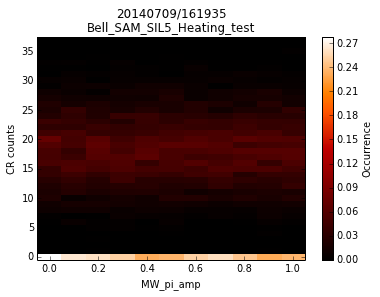

In [85]:
a.get_cr_results(name)
a.plot_cr_vs_sweep()

X:\data\20140709\170331_Bell_BS_tpqi_parallel_BS_SAM_SIL5_Tail_sweep_12deg\170331_Bell_BS_tpqi_parallel_BS_SAM_SIL5_Tail_sweep_12deg.hdf5
Total clicks: 3360


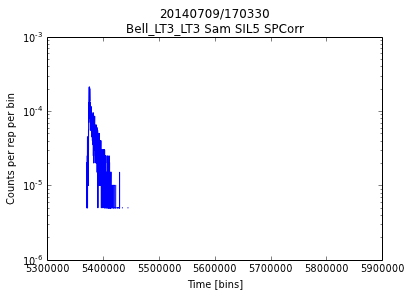

In [135]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
folder=tb.latest_data('Bell')
#folder=tb.data_from_time('20140609183154')
#folder=r'D:\measuring\data\20140519\192030_Bell_lt3_tailS_The111no2_SIL1_Ey_+11deg'
name = 'ssro'
a = pqsequence.TailAnalysis(folder, hdf5_mode='r', pq_folder='bs_remote')
a.reps=200000
a.plot_histogram(0,start=5.370e6, length=500000, hist_binsize=100, save=False, log_plot=False)

In [2]:
from analysis.lib.pq import pq_tools
reload(pq_tools)

ImportError: No module named analysis.lib.pq

In [122]:
fltr0=pq_tools.filter_synctimes(a.pqf, 5371.5e3, 5397e3,15,600e3)
fltr1=pq_tools.filter_synctimes(a.pqf, 5374e3, 5399.5e3,15,600e3)
cs=pq_tools.get_coincidences(a.pqf, fltr0, fltr1)
dts_ns = cs[:,0]*1e-3
len(cs)

6630

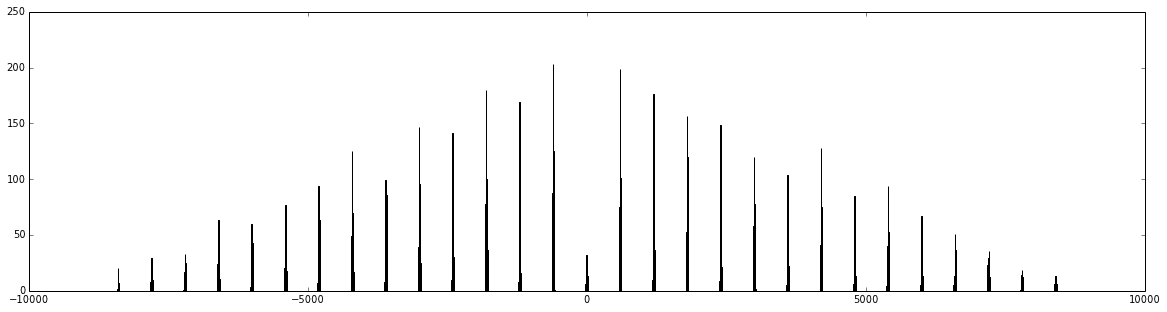

In [126]:
binsize=10
G2_BINEDGES = arange(-19000,19000,binsize)
#G2_BINEDGES = np.hstack((arange(-700,-500,binsize),arange(-100,100,binsize),arange(500,700,binsize)))
#print G2_BINEDGES
figure(figsize=(20,5))
b_=hist(dts_ns, bins=G2_BINEDGES)